In [2]:
import numpy as np
import matplotlib.pyplot as plt

def kernel_rbf(a, b, L):

    if not isinstance(a, np.ndarray) or a.ndim != 2:
        raise ValueError(f"Input 'a' must be a 2D numpy array. Got shape {a.shape}")
    if not isinstance(b, np.ndarray) or b.ndim != 2:
        raise ValueError(f"Input 'b' must be a 2D numpy array. Got shape {b.shape}")
    if a.shape[1] != b.shape[1]:
        raise ValueError(f"Inputs 'a' and 'b' must have the same number of features (columns). "
                         f"Got a.shape[1] = {a.shape[1]} and b.shape[1] = {b.shape[1]}")
    if not (isinstance(L, (int, float)) and L > 0):
        raise ValueError(f"Parameter 'L' must be a positive number. Got {L}")

    sq_dists = np.ones((a.shape[0], b.shape[0]))
    
    for i in range(a.shape[0]):
        
        for j in range(b.shape[0]):
            
            sq_dists[i, j] = np.power(np.linalg.norm(a[i, :] - b[j, :], 2), 2)
    
    return np.exp(-L * sq_dists)



class GaussianProcessRegressorRBF: 

    def __init__(self, kernel_L, lmbd, input_dim=1):

        self.kernel_L = kernel_L
        self.lmbd = lmbd  
        self.input_dim = input_dim

    
    def load_data(self, x, y):

        self.n_samples = x.shape[0]

        self.x_vect = np.array([x]).reshape(self.n_samples, self.input_dim)
        self.y_vect = np.array([y]).reshape(self.n_samples, 1)
        
        self.K_matrix = kernel_rbf(self.x_vect, self.x_vect, self.kernel_L) \
                        + self.lmbd * np.eye(self.n_samples)
        self.K_matrix_inv = np.linalg.solve(self.K_matrix, np.eye(self.n_samples))


    def compute(self, x):

        assert x.ndim == 2 and x.shape[1] == self.input_dim, "compute() function: Error in input"
        
        n = x.shape[0]
        
        mu = np.zeros(n)
        sigma = np.zeros(n)
        
        for i in range(n):
            K_star = kernel_rbf(self.x_vect, x[i, :].reshape(1, self.input_dim), self.kernel_L)
            mu[i] = K_star.T @ self.K_matrix_inv @ self.y_vect
            sigma[i] = kernel_rbf(x[i, :].reshape(1, self.input_dim), x[i, :].reshape(1, self.input_dim), 
                                  self.kernel_L) - K_star.T @ self.K_matrix_inv @ K_star
        
        return mu, sigma

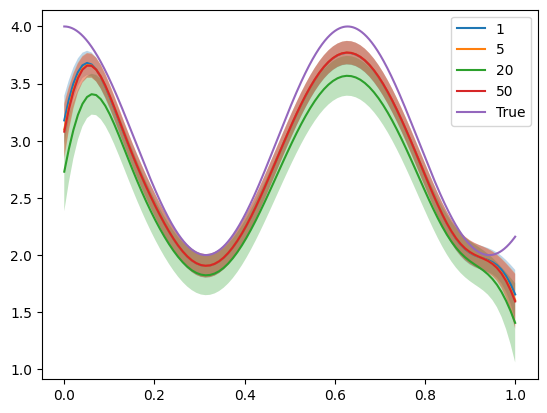

In [3]:
x_plt = np.linspace(0, 1, 100).reshape(-1, 1)
kernel_L = 100

n_samples_list = [100, 500, 1000, 5000]
lmbd_list = [1, 5, 20, 50]

for n_samples, lmbd in zip(n_samples_list, lmbd_list): 
    
    x = np.linspace(0, 1, n_samples).reshape(-1, 1)
    y = 3 + np.cos(x*10)
    
    regressor = GaussianProcessRegressorRBF(kernel_L, lmbd)

    regressor.load_data(x, y)

    y_hat, sigma_hat = regressor.compute(x_plt)

    plt.plot(x_plt.ravel(), y_hat, label=lmbd)
    plt.fill_between(x_plt.ravel(), y_hat - sigma_hat, y_hat + sigma_hat, alpha=0.3)

plt.plot(x, y, label="True")
plt.legend()